In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from torch import nn
from transformers import GPT2Tokenizer, GPT2Config, GPT2Model, GPT2PreTrainedModel
from torch.optim import AdamW
from datasets import load_dataset
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_built() else 'cpu'
print(device)

cuda


In [ ]:
dataset = load_dataset("gigant/ted_descriptions")
print(dataset)
print(len(dataset['train']))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/683 [00:00<?, ?B/s]

(…)-00000-of-00001-c35c348d686618cf.parquet:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5705 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['url', 'descr'],
        num_rows: 5705
    })
})
5705


In [ ]:
for i in range(5):
  print(dataset['train'][i])

{'url': 'https://www.ted.com/talks/jen_gunter_how_your_sense_of_smell_helps_you_savor_flavor', 'descr': "Eating pizza with a stuffy nose just isn't as satisfying -- and there's a reason for that. Dr. Jen Gunter explains how our ability to smell and taste work together to give us a full sensory experience. So whether you're sniffing the caramelized aroma of coffee, a whiff of trash or a trillion other things, your brain knows exactly what's under your nose. For more on how your body works, tune into her podcast, Body Stuff with Dr. Jen Gunter, from the TED Audio Collective."}
{'url': 'https://www.ted.com/talks/ryan_heffington_how_dance_can_unleash_your_inner_joy', 'descr': '"We all have our own beautiful ways of moving, and this is worth celebrating," says dancer and choreographer Ryan Heffington. Inviting you to reconsider your connection to dance, he shows how even everyday experiences -- tying your shoes, rocking a baby, whisking up some mac and cheese -- can offer choreographic insp

In [ ]:
text_corpus = [f"{txt} <|endoftext|>" for i, txt in enumerate(dataset['train']['descr'])]
print(text_corpus[0])

Eating pizza with a stuffy nose just isn't as satisfying -- and there's a reason for that. Dr. Jen Gunter explains how our ability to smell and taste work together to give us a full sensory experience. So whether you're sniffing the caramelized aroma of coffee, a whiff of trash or a trillion other things, your brain knows exactly what's under your nose. For more on how your body works, tune into her podcast, Body Stuff with Dr. Jen Gunter, from the TED Audio Collective. <|endoftext|>


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', pad_token= '<|pad|>')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
input_text = "Hello my country <|endoftext|><|endoftext|><|pad|><|pad|><|pad|>"
tokenizer_input_text = tokenizer(input_text)['input_ids']
print(tokenizer_input_text)

[15496, 616, 1499, 220, 50256, 50256, 50257, 50257, 50257]


In [ ]:
print(' '.join(tokenizer.convert_ids_to_tokens(tokenizer_input_text)))

Hello Ġmy Ġcountry Ġ <|endoftext|> <|endoftext|> <|pad|> <|pad|> <|pad|>


In [ ]:
class GPT2_model(GPT2PreTrainedModel):

  def __init__(self, config):
    super().__init__(config)
    self.transformer = GPT2Model.from_pretrained('gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', pad_token= '<|pad|>')

    self.transformer.resize_token_embeddings(len(tokenizer))
    self.lm_head = nn.Linear(config.n_embd, len(tokenizer), bias=False)

  def forward(self, input_ids, attention_mask=None, token_type_ids=None):

    x = self.transformer(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
    x=self.lm_head(x)
    return x


[108, 106, 90, 114, 80, 77, 56, 106, 82, 95, 89, 100, 93, 121, 38, 100, 98, 122, 71, 120, 60, 106, 49, 113, 111, 79, 77, 103, 34, 132, 71, 56, 97, 148, 106, 101, 91, 75, 107, 94, 86, 120, 104, 115, 125, 100, 65, 83, 116, 100, 119, 38, 116, 36, 76, 89, 113, 33, 102, 68, 207, 123, 105, 95, 35, 79, 115, 91, 116, 119, 88, 75, 52, 76, 73, 90, 92, 68, 61, 81, 120, 82, 106, 116, 110, 69, 77, 117, 109, 100, 98, 109, 70, 96, 116, 75, 110, 114, 101, 93, 65, 118, 100, 141, 80, 76, 112, 96, 113, 34, 157, 130, 84, 110, 82, 92, 119, 101, 84, 93, 108, 94, 83, 89, 98, 119, 99, 85, 81, 109, 99, 74, 92, 83, 56, 92, 73, 48, 93, 102, 117, 87, 88, 100, 149, 138, 152, 128, 112, 99, 65, 113, 49, 45, 61, 171, 164, 86, 86, 101, 93, 145, 119, 121, 146, 123, 101, 70, 153, 86, 117, 100, 100, 116, 96, 98, 66, 108, 129, 84, 51, 97, 63, 99, 114, 79, 59, 111, 81, 68, 52, 104, 107, 95, 108, 66, 108, 127, 99, 117, 87, 130, 67, 118, 106, 52, 126, 120, 90, 115, 50, 173, 46, 103, 154, 115, 91, 112, 108, 100, 89, 102, 113,

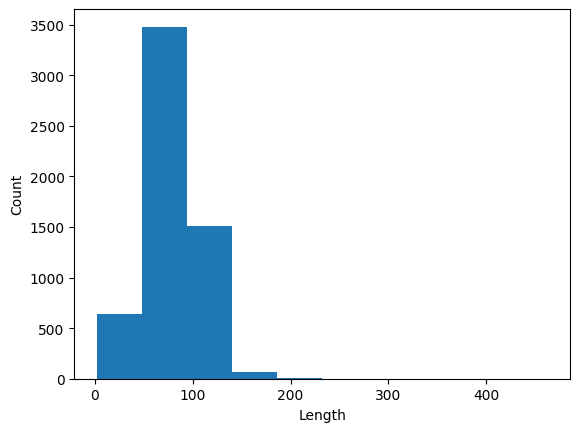

In [ ]:
tokenized_inp_len = [len(tokenizer(txt)['input_ids']) for txt in text_corpus]
print(tokenized_inp_len)

np.random.seed(42)
x = np.asarray(tokenized_inp_len)

plt.hist(x, density=False, bins=10)
plt.ylabel('Count')
plt.xlabel('Length')
plt.show()

In [ ]:
class TedDataset(torch.utils.data.Dataset):
  def __init__(self, input_data, tokenizer, gpt2_type="gpt2", max_length=256):
    self.texts = [tokenizer(data, truncation=True, max_length=max_length, padding="max_length", return_tensors="pt" )]

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    return self.texts[idx]

In [ ]:
data = ["Hello, how are you?", "This is a test sentence"]
dataset = TedDataset(data, tokenizer)
print(len(dataset))
print(dataset[0])
print(data[1])

1
{'input_ids': tensor([[15496,    11,   703,   389,   345,    30, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257,

In [ ]:
class CrossEntropyLossFunction(nn.Module):
  def __init__(self):

    super(CrossEntropyLossFunction, self).__init__()
    self.loss_fct = nn.CrossEntropyLoss()

  def forward(self, lm_logits, labels):

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        loss = self.loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return loss

In [ ]:
def train(model, tokenizer, train_data, epochs, learning_rate, epsilon=1e-8):

  train = TedDataset(train_data, tokenizer)
  train_dataloader = torch.utils.data.DataLoader(train, batch_size=2,shuffle=True)

  optimizer = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)
  criterion = CrossEntropyLossFunction().to(device)
  model = model.to(device)

  best_loss = 1000

  for epoch_i in range(0,epochs):

    total_train_loss = 0
    total_val_loss = 0
    for train_input in tqdm(train_dataloader):

      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].to(device)

      outputs = model(input_id, attention_mask= mask,
                      token_type_ids=None)
      loss = criterion(outputs, input_id)
      batch_loss = loss.item()
      total_train_loss += batch_loss
      model.zero_grad()
      loss.backward()
      optimizer.step()
      model.zero_grad()
    avg_train_loss = total_train_loss / len(train_dataloader)

    print(f"Epoch: {epoch_i}, Avg  train loss: {np.round(avg_train_loss,2)}")


In [ ]:
epochs = 100
learning_rate = 1e-5
configuration = GPT2Config()
gpt_model = GPT2_model(configuration).to(device)
print(configuration)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


GPT2Config {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.48.3",
  "use_cache": true,
  "vocab_size": 50257
}



In [ ]:
print(gpt_model)

GPT2_model(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)


In [ ]:
train(gpt_model, tokenizer, text_corpus, epochs, learning_rate)

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch: 0, Avg  train loss: 10.81


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


Epoch: 1, Avg  train loss: 10.24


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch: 2, Avg  train loss: 9.8


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch: 3, Avg  train loss: 9.43


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Epoch: 4, Avg  train loss: 9.1


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Epoch: 5, Avg  train loss: 8.77


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


Epoch: 6, Avg  train loss: 8.39


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


Epoch: 7, Avg  train loss: 7.98


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Epoch: 8, Avg  train loss: 8.0


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Epoch: 9, Avg  train loss: 7.38


100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Epoch: 10, Avg  train loss: 7.17


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Epoch: 11, Avg  train loss: 6.94


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Epoch: 12, Avg  train loss: 6.68


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Epoch: 13, Avg  train loss: 6.38


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Epoch: 14, Avg  train loss: 6.02


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Epoch: 15, Avg  train loss: 5.58


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 16, Avg  train loss: 5.07


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


Epoch: 17, Avg  train loss: 4.51


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Epoch: 18, Avg  train loss: 3.91


100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


Epoch: 19, Avg  train loss: 3.31


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch: 20, Avg  train loss: 2.74


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Epoch: 21, Avg  train loss: 2.26


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch: 22, Avg  train loss: 1.85


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


Epoch: 23, Avg  train loss: 1.5


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


Epoch: 24, Avg  train loss: 1.2


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Epoch: 25, Avg  train loss: 0.96


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 26, Avg  train loss: 0.76


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Epoch: 27, Avg  train loss: 0.63


100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Epoch: 28, Avg  train loss: 0.54


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


Epoch: 29, Avg  train loss: 0.48


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Epoch: 30, Avg  train loss: 0.44


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Epoch: 31, Avg  train loss: 0.41


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Epoch: 32, Avg  train loss: 0.39


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Epoch: 33, Avg  train loss: 0.38


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Epoch: 34, Avg  train loss: 0.37


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Epoch: 35, Avg  train loss: 0.36


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch: 36, Avg  train loss: 0.35


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Epoch: 37, Avg  train loss: 0.34


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Epoch: 38, Avg  train loss: 0.33


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Epoch: 39, Avg  train loss: 0.33


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch: 40, Avg  train loss: 0.32


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Epoch: 41, Avg  train loss: 0.32


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Epoch: 42, Avg  train loss: 0.31


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Epoch: 43, Avg  train loss: 0.31


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 44, Avg  train loss: 0.31


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 45, Avg  train loss: 0.31


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Epoch: 46, Avg  train loss: 0.3


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Epoch: 47, Avg  train loss: 0.3


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Epoch: 48, Avg  train loss: 0.3


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 49, Avg  train loss: 0.3


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 50, Avg  train loss: 0.3


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch: 51, Avg  train loss: 0.3


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Epoch: 52, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Epoch: 53, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Epoch: 54, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Epoch: 55, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Epoch: 56, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch: 57, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Epoch: 58, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Epoch: 59, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Epoch: 60, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Epoch: 61, Avg  train loss: 0.29


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Epoch: 62, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Epoch: 63, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


Epoch: 64, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch: 65, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Epoch: 66, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 67, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Epoch: 68, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Epoch: 69, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Epoch: 70, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Epoch: 71, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


Epoch: 72, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch: 73, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Epoch: 74, Avg  train loss: 0.28


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Epoch: 75, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 76, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Epoch: 77, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 78, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Epoch: 79, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 80, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch: 81, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Epoch: 82, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Epoch: 83, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Epoch: 84, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


Epoch: 85, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Epoch: 86, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Epoch: 87, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Epoch: 88, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Epoch: 89, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Epoch: 90, Avg  train loss: 0.27


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch: 91, Avg  train loss: 0.26


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Epoch: 92, Avg  train loss: 0.26


100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Epoch: 93, Avg  train loss: 0.26


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Epoch: 94, Avg  train loss: 0.26


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


Epoch: 95, Avg  train loss: 0.26


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Epoch: 96, Avg  train loss: 0.26


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Epoch: 97, Avg  train loss: 0.26


100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


Epoch: 98, Avg  train loss: 0.26


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

Epoch: 99, Avg  train loss: 0.26


In [ ]:
from google.colab import drive
import torch
from transformers import GPT2Config, GPT2LMHeadModel

# Mount Google Drive
drive.mount('/content/drive')

# Define the correct model path
model_dir = "/content/drive/My Drive"  # Update this with your actual path

# Load GPT-2 model
configuration = GPT2Config()
gpt_model = GPT2LMHeadModel(configuration).to(device)  # Ensure correct model class

# Load state dictionary safely
try:
    gpt_model.load_state_dict(torch.load(model_dir, map_location=device))
    print("Model loaded successfully!")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_dir}. Check the path.")

# Set to evaluation mode
gpt_model.eval()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-34-fbd8bd8ccd45>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gpt_model.load_state_dict(torch.load(model_dir, map_location=device))


IsADirectoryError: [Errno 21] Is a directory: '/content/drive/My Drive'

In [ ]:
import torch
import torch.nn.functional as F

def generate(idx, max_new_tokens, context_size, tokenizer, model, top_k=10, top_p=0.95):
    for _ in range(max_new_tokens):
        # Stop if the last token is the EOS token
        if idx[:, -1].item() == tokenizer.encode(tokenizer.eos_token, add_special_tokens=False)[0]:
            break

        # Crop idx to the last `context_size` tokens
        idx_cond = idx[:, -context_size:]

        # Get model predictions (logits)
        # The model may return a tuple, we only need the logits which is the first element in the tuple
        outputs = model(idx_cond)
        logits = outputs.logits  # Assuming the logits are available as outputs.logits for GPT2LMHeadModel

        # Select logits of the last token
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1)

        # Apply top-k filtering
        if top_k > 0:
            top_k_values, top_k_indices = torch.topk(probs, top_k)
            probs = top_k_values
            indices = top_k_indices
        else:
            sorted_probs, indices = torch.sort(probs, descending=True)

        # Apply top-p (nucleus) sampling
        sorted_probs, indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

        # Keep only tokens with cumulative probability mass <= top_p
        filtered_indices = cumulative_probs <= top_p
        sorted_probs = sorted_probs[:, filtered_indices[0]]
        indices = indices[:, filtered_indices[0]]

        # Normalize the remaining probabilities
        sorted_probs = F.softmax(sorted_probs, dim=-1)

        # Sample the next token
        idx_next = indices[:, torch.multinomial(sorted_probs, num_samples=1)]

        # Append new token ids
        # The issue was with the shape of idx_next, which was (1, 1, 1)
        # We need to squeeze it to (1, 1) before concatenating
        idx = torch.cat((idx, idx_next.squeeze(-1)), dim=1)

    return idx  # Ensure only the token tensor is returned


In [ ]:
gpt_model.eval()

prompt = "How will AI impact"
generated = tokenizer.encode(prompt, return_tensors="pt").to(device)

generated_tokens = generate(
    generated,
    max_new_tokens=100,
    context_size=256,
    tokenizer=tokenizer,
    model=gpt_model,
    top_k=10,
    top_p=0.95
)

# Decode and print the generated text
print(tokenizer.decode(generated_tokens[0].cpu().numpy(), skip_special_tokens=True))


How will AI impact%""'##'"!#"$&'$)!()*")((&&%&*#!*"%($*&&'&))"&*!#***'"#%&**$&*$!"&"%'"*#)&%)"))%('($"'"!#!(%!#!')!"#*


In [ ]:
gpt_model.eval()

prompt = "How will AI impact"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = generate(generated,
                         max_new_tokens=100,
                         context_size=256,
                         tokenizer=tokenizer,
                         model=gpt_model,
                         top_k=10,
                         top_p=0.95)

for i, sample_output in enumerate(sample_outputs):
    print(f"{tokenizer.decode(sample_output, skip_special_tokens=True)}")

How will AI impact*%")**$#*(%"%)$"!))!)%!%"!)###!)%")#)"!"%(&"#)$*&#!(!*#**&""&!(!(!)'*#'"*#'#%*&(!#(%$'(#)%"("!*'")&&
